# DIABETES LEARNING



In [70]:
isGoogleColab = True

# Notes

- check these blog posts: https://muellerzr.github.io/fastblog/ and his course: https://walkwithfastai.com/intro.contribute
- learner.export() already save all the transforms that will be applied during inference time, so it is not necessary to resize or normalize stats. If running outside the model outside fastai, check: https://forums.fast.ai/t/do-we-need-to-normalize-single-image-before-running-predict-function-on-it/44301/4
- to_fp16() is mixed precision
- item_tfms already apply the resize before collating the images in a batch. So it is not necessary to do this manually
- aug_tfms will only be applied on train_dl. validation and test will not be affected
- test_dl is a testing dataloader that uses the same transforms as train_dl and valid_dl, but with new data
- check images cleaner in the future
- cross validation: check walkwithfastai video 3 or https://forums.fast.ai/t/is-it-possible-to-implement-cross-validation-in-fastai/44961/15 or https://forums.fast.ai/t/am-i-doing-k-fold-cross-validation-right/84738/6  
- stratification in Kfold and Train_Test split for Multi Label problems is not straighforward. Check http://scikit.ml/index.html#. Use for now balanced datasets!!!!



# Installation

## Kill all other GPU sessions

Run the first time this cell. Then, restart your session and run again the notebook without this code.

In [71]:
  #!kill -9 -1

## Keep Session Alive

Put this javascript code in the browser console

In [72]:
# function ClickConnect(){
#    console.log("Working");
#    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }  setInterval(ClickConnect,300000)

## Update ipython/ipykernel (Colab)

The Colab session can fail when running the first time this cell. Just run it a second time.

In [73]:
# This magic cell should be put first in your colab notebook. 
# It'll automatically upgrade colab's really antique ipython/ipykernel to their 
# latest versions which are required for packages like ipyexperiments 

# from packaging import version
# import IPython, ipykernel
# IPython.__version__
# if version.parse(IPython.__version__) <= version.parse("5.5.0"):
#     !pip install -q --upgrade ipython
#     !pip install -q --upgrade ipykernel
    
#     import os
#     import signal
#     os.kill(os.getpid(), signal.SIGTERM)
# print(f"ipykernel=={ipykernel.__version__}")
# print(f"IPython=={IPython.__version__}")

In [74]:
# new (large)
# !pip install ipyexperiments
# new (large)
# from ipyexperiments import IPyExperimentsPytorch
# exp = IPyExperimentsPytorch()

## Check GPU e CPU RAM

In [75]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if isGoogleColab and torch.cuda.is_available():
    from pynvml import *
    nvmlInit()
    def log_mem():
        h = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(h)
        print(f'GPU total Memory    : {info.total}')
        print(f'GPU free Memory     : {info.free}')
        print(f'GPU Memory used     : {info.used}')
    torch.ones(1).to(0)
    log_mem()
#     !nvidia-smi

GPU total Memory    : 11996954624
GPU free Memory     : 10566303744
GPU Memory used     : 1430650880


## Mount the Google Drive to Google Colab

In [76]:
if isGoogleColab:
    from google.colab import drive
    import sys
    drive.mount('/content/drive', force_remount=True)
    path_to_drive = "/content/drive/MyDrive/Colab Notebooks/"
    sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/') #make src files importable

else:
    path_to_drive = "./"

Mounted at /content/drive


In [77]:
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset_v2.rar" "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset.rar" # extrai local
#!unzip "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/database.zip" -d "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"

## Install Deep Learning libraries

In [78]:
# !pip install albumentations==1.1.0
# !pip install pytorch-lightning==1.4.8
# !pip install torchmetrics==0.6.2
# !pip install wandb==0.12.7
# !pip install fastai==2.5.3

# ##restart runtime!!!

In [79]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)

Python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Pytorch: 1.10.0+cu111


# Data

In [80]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
import torch
import torchvision
from PIL import Image
import timeit


In [81]:
pathBrazil = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/'
pathBrazil_anno = pathBrazil + 'gt/'
pathBrazil_img = pathBrazil + 'done/'

pathUnimib = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/' 
pathUnimib_anno = pathUnimib + 'gt/'
pathUnimib_img = pathUnimib + 'done/'


In [105]:
np.random.seed(2) #mesma semente para todas as vezes que executar
randomSeed = 2

fnamesBrazil = get_image_files(pathBrazil_img)
print(fnamesBrazil[:3])

fnamesUnimib = get_image_files(pathUnimib_img)
print(fnamesUnimib[:-3])

fnames = fnamesBrazil + fnamesUnimib
path = pathBrazil 
len(fnames)

[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/231.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/677.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/526.jpeg')]
[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151127_121649.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151127_121831.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151127_121903.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151127_121906.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151127_121953.jpg

1496

In [106]:
# Food detection or Multi Class Classification?
isFoodDetectionOnly = True

if isFoodDetectionOnly: 
  codes = ["Void","Food"]
  codesId = [0, 1]

else:
  codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')

  ### classesNumber Brazil dataset 
  codesId = [code.split(": ")[0] for code in codes]
  codes = [code.split(": ")[1] for code in codes] #pega apenas o nome de cada classe e ignora o ID

  ### classesNumber Unimib dataset
  # codes = list(codes)
  # codesId = list(range(0, len(codes)))


len(codes)

2

In [107]:
### fix GT ids: masks must be [0, 1, …, K-1] where K is the number of categories

def get_y_fn(item):
  "Grab a mask from a `filename` and adjust the pixels based on `adjustedGroundTruthIds`"
  if "sprint0" in str(item):
    itemGtPath = pathBrazil_anno + '/' + f'{item.stem}_GT.png'
  elif "UNIMIB" in str(item):
    itemGtPath = pathUnimib_anno + '/' + f'{item.stem}GT.png'

  msk = PILMask.create(itemGtPath)
  
  if not isFoodDetectionOnly: # adjust ground truth ids only with is Multi Class Classification
    msk = np.array(msk)
    for i, val in enumerate(adjustedGroundTruthIds):
      msk[msk==adjustedGroundTruthIds[i]] = val
    msk = PILMask.create(msk)

  return msk

adjustedGroundTruthIds = dict()
adjustedGroundTruthIds = {i : int(codesId[i]) for i in range(len(codes))}

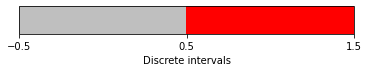

In [108]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) # nao alimento -> cinza
cmaplist[1] = "red" # nao registrado
if not isFoodDetectionOnly:
  cmaplist[2] = "yellow" #arroz integral
  cmaplist[3] = "blue" #arroz branco
  cmaplist[4] = "green" #feijao

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervalos devem conter apenas o numero inteiro, entao ir de 0.5 em 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

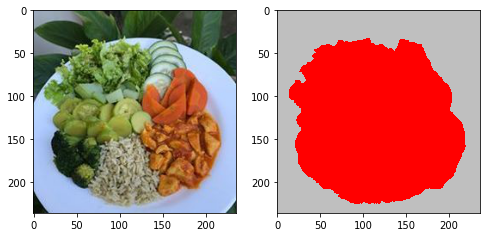

Ground truth Codes [ 0  2 60 65 73 74 75 93]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/181.jpg


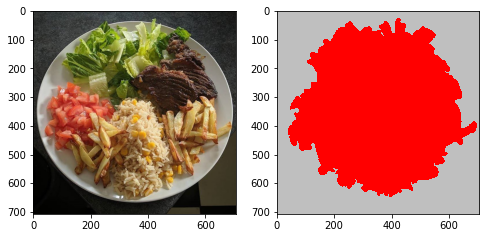

Ground truth Codes [ 0  3 53 65 72 91]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/813.jpg


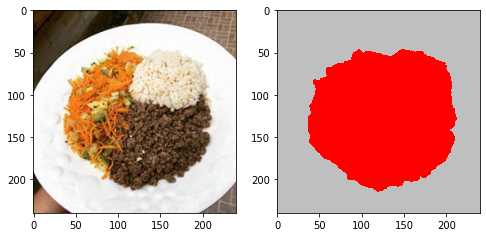

Ground truth Codes [ 0  3 57 89]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/773.jpg


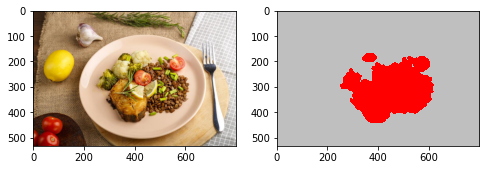

Ground truth Codes [  0  20  58  72  73 106]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/870.jpg


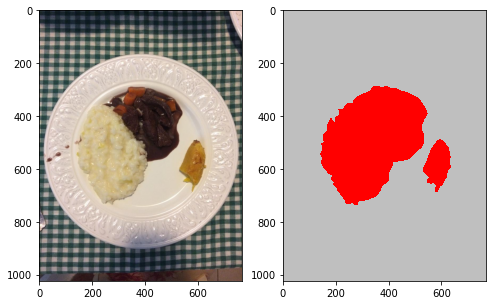

Ground truth Codes [  0  24  54 100]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/459.jpeg


In [109]:
### VISUALIZACAO DA MÁSCARA FICA COM A BORDA ESTRANHA, MAS ELA ESTÁ CORRETA COMO PODE SER VISTO NOS CODIGOS DO GROUND TRUTH

for idx in range(200,205):
  fig = plt.figure(figsize=(8,8))

  img = Image.open(fnames[idx])
  arr = np.asarray(img)
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(arr)

  img1 = get_y_fn(fnames[idx]) # use this when 'adjustedGroundTruthIds' is necessary
  # img1 = Image.open(get_y_fn(fnames[idx]))
  arr = np.asarray(img1)
  ax1 = fig.add_subplot(1,2,2)
  ax1.imshow(arr, cmap=cmap, norm=norm)
  plt.show()

  print("Ground truth Codes", np.unique(arr,return_counts=False))
  print(fnames[idx])


# MaskRCNN Utils

In [158]:
from torchvision import transforms as T
from mpl_toolkits.axes_grid1 import ImageGrid
import math
import cv2

# resize all images before training! this is the default value for this whole notebook
imageSize = 256

def get_prediction(img_path, threshold, codes, model):
  img = Image.open(img_path)
  transform = T.Compose([T.Resize((imageSize,imageSize)), T.ToTensor()])
  img = transform(img).to(device)
  pred = model([img])

  pred_score = list(pred[0]['scores'].detach().cpu().numpy()) # the scores come sorted from the highest value

  # get all objects with score higher than threshold
  valid_preds = [pred_score.index(x) for x in pred_score if x>threshold]
  if len(valid_preds) == 0:
    return [],[],[],[]
  
  lastValidDetection = valid_preds[-1] + 1
  
  # take scores, masks, class names and boxes until the object with the lowest score (but all scores are higher than the threshold) 
  scores = pred_score[:lastValidDetection]

  masks = (pred[0]['masks']>0.5).detach().cpu().numpy()
  masks = [mask.squeeze() for mask in masks]
  masks = masks[:lastValidDetection]

  pred_class = [codes[i] for i in list(pred[0]['labels'].cpu().numpy())]
  classes = pred_class[:lastValidDetection]

  pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  boxes = pred_boxes[:lastValidDetection]
  
  return masks, boxes, classes, scores

def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

def drawPrediction(img, masks, boxes, pred_cls, pred_scores, threshold=0.5, rect_th=1, text_size=0.5, text_th=2):
  fig = plt.figure(figsize=(20, 20))
  cols = 8
  rows = math.ceil(max(1, len(masks)/cols))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                   nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                   axes_pad=0.5,  # pad between axes in inch.
                  )
  
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img_clone = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img_clone, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    text = pred_cls[i] + ": " + "{:.2f}%".format(pred_scores[i] * 100)
    cv2.putText(img_clone, text, boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    grid[i].imshow(img_clone)

  # plt.figure(figsize=(4,4))
  # plt.imshow(img) #replace img_clone for img to get all predictions in just one image
  plt.show()

def instance_segmentation_api(img_path, codes, model, threshold=0.5):
  masks, boxes, pred_cls, pred_scores = get_prediction(img_path, threshold, codes, model)
  
  img = Image.open(img_path).convert("RGB")
  img = img.resize((imageSize,imageSize))
  img = np.asarray(img)
  drawPrediction(img, masks, boxes, pred_cls, pred_scores, threshold)


In [111]:
# util functions to concatenate masks when calculating acc_segmentation and miou

import functools

def concatMasks(mask1, mask2):
  bothNotZero = torch.logical_and(mask1, mask2)
  mask2[bothNotZero] = 0
  return mask1+mask2

def concatenateAndFlattenMasks(y_pred, y_true, threshold, pytorchDevice):
  flat_pred = torch.tensor([], device=pytorchDevice)
  flat_target = torch.tensor([], device=pytorchDevice)

  for pred, gt in zip(y_pred, y_true): #iterate every element in the batch and concatenate masks above certain threshold
    pred_masksWithLabel = []
    gt_masksWithLabel = []
    for pred_id, pred_mask, pred_score in zip(pred["labels"], pred["masks"], pred["scores"]):
      if pred_score > threshold:
        pred_mask = torch.round(pred_mask)
        pred_mask = torch.as_tensor(pred_mask, dtype=torch.uint8, device=pytorchDevice)
        pred_masksWithLabel.append(pred_mask*pred_id)
    for gt_id, gt_mask in zip(gt["labels"], gt["masks"]):
      gt_masksWithLabel.append(gt_mask*gt_id)
    
    if len(pred_masksWithLabel) == 0:
      concatenatedPreds = torch.zeros(gt_masksWithLabel[0].size(), device=pytorchDevice)
    else:
      concatenatedPreds = functools.reduce(concatMasks, pred_masksWithLabel)
    concatenatedGts = functools.reduce(concatMasks, gt_masksWithLabel)
    flat_pred = torch.cat((flat_pred, concatenatedPreds.flatten()), dim=0)
    flat_target = torch.cat((flat_target, concatenatedGts.flatten()), dim=0)

    # fig = plt.figure(figsize=(8,8))
    # ax1 = fig.add_subplot(1,2,1)
    # ax1.imshow(concatenatedPreds.squeeze().detach().numpy(), cmap=cmap, norm=norm)
    # ax1 = fig.add_subplot(1,2,2)
    # ax1.imshow(concatenatedGts.squeeze().detach().numpy(), cmap=cmap, norm=norm)
    # plt.show()

  return flat_pred.long(), flat_target.long()

# Pytorch Implementation

## Dataset

In [112]:
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T

import torch

class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, fnames, foodDetectionOnly=False, transforms=None):
        self.fnames = fnames
        self.transforms = transforms
        self.foodDetectionOnly = foodDetectionOnly

    def __fixDegeneratedBoundingBox(self, xmin, ymin, xmax, ymax):
        print("Degenerated bounding box!!!!!!! Fixing error")
        if xmin == xmax and xmin == 0:
          xmax = 1
        elif xmin == xmax and xmin == 255:
          xmin = 254

        if ymin == ymax and ymin == 0:
          ymax = 1
        elif ymin == ymax and ymin == 255:
          ymin = 254
        
        return xmin, ymin, xmax, ymax

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx]).convert("RGB")
        img = np.asarray(img)
        mask = get_y_fn(self.fnames[idx]) 
        mask = np.asarray(mask)

        # data augmentation
        if self.transforms is not None:
            transformed = self.transforms(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if (xmin == xmax) or (ymin == ymax):
              xmin, ymin, xmax, ymax = self.__fixDegeneratedBoundingBox(xmin, ymin, xmax, ymax)

            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        img = F.to_tensor(img)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        if self.foodDetectionOnly:
          # there is only one class for food detection
          labels = torch.ones((num_objs,), dtype=torch.int64)
        else:
          labels = torch.as_tensor(obj_ids, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks


        ###### IGNORE THIS: it is necessary to be compatible with COCO dataset and torchvision engine
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        ######

        return img, target

    def __len__(self):
        return len(self.fnames)


In [113]:
# get data split from files or function

#### split train/test randomly ####
#from sklearn.model_selection import train_test_split
#X_train, X_test, _, _ = train_test_split(fnames, label_fnames, test_size=0.2, random_state=randomSeed, shuffle=True, stratify=None)

#### split by validation.txt (UNIMIB) ####
# testFiles = np.loadtxt(path + 'validation.txt', dtype=str, delimiter='\n',encoding='utf')
# X_test = [file for file in fnames if file.name in testFiles]
# X_train = [file for file in fnames if file.name not in testFiles]

#### split by filenames array from pickle (BRAZIL DATASET) ####
import pickle
with open(path + "testFilenames.pkl", 'rb') as f:
  testFiles = pickle.load(f)
X_test = [file for file in fnames if file.name in testFiles]
X_train = [file for file in fnames if file.name not in testFiles]

len(X_train), len(X_test)

(1389, 107)

## Data Augmentation

In [114]:
import albumentations as A
import cv2

def get_transforms(train: bool):
    transforms = []
    transforms.append(A.Resize(imageSize,imageSize)) 
    if train:
      transforms += [

                    ### SPATIAL
                    A.Flip(p=0.5),
                    A.RandomRotate90(p=0.5),
                    A.ShiftScaleRotate(p=0.5, rotate_limit=25, border_mode=cv2.BORDER_REPLICATE),
                    A.OneOf([
                        A.ElasticTransform(p=1, border_mode=cv2.BORDER_REPLICATE),
                        A.GridDistortion(p=1, border_mode=cv2.BORDER_REPLICATE),
                    ], p=0.2),

                    ### COLOR / NOISE
                    A.RGBShift(p=0.5, r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
                    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
                    A.OneOf([
                      A.Blur(p=1),
                      A.GaussNoise(p=1),
                      A.CLAHE(p=1),
                    ], p=0.2),
                     
                    ]

    return A.Compose(transforms)

## Dataloaders

In [115]:
def collate_fn(batch):
    return tuple(zip(*batch))

bs = 4 # batch size

trainset = FoodDataset(X_train, foodDetectionOnly=isFoodDetectionOnly, transforms=get_transforms(train=True))
trainDataloader = torch.utils.data.DataLoader(
 trainset, batch_size=bs, shuffle=True, num_workers=2,
 collate_fn=collate_fn)

testset = FoodDataset(X_test, foodDetectionOnly=isFoodDetectionOnly, transforms=get_transforms(train=False))
testDataloader = torch.utils.data.DataLoader(
 testset, batch_size=bs, shuffle=False, num_workers=2,
 collate_fn=collate_fn)

len(trainset), len(testset)

(1389, 107)

## Visualize dataset

In [116]:
dataset2visualize = trainset

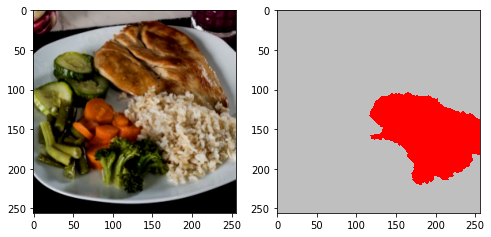

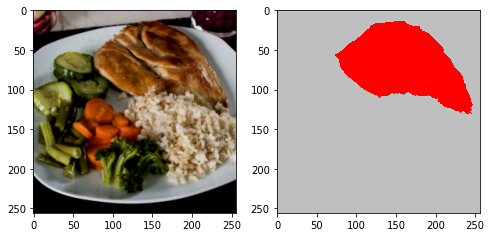

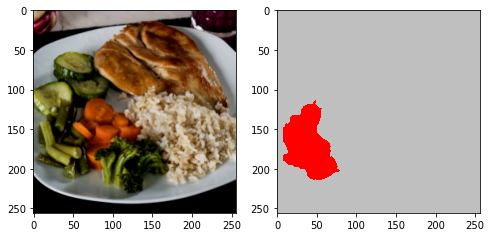

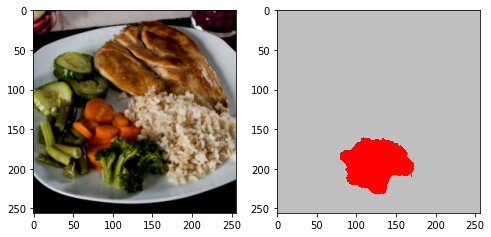

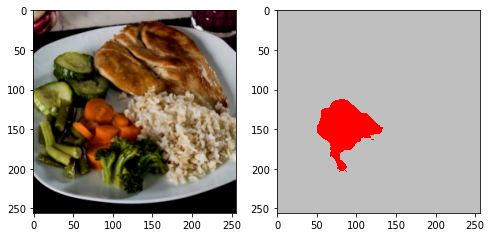

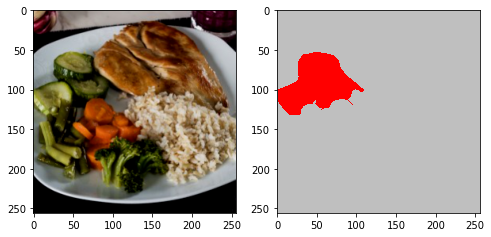

In [118]:
# show multiple masks from objects

idx = 0
img, label = dataset2visualize[idx]
img = img.permute(1,2,0).numpy() # tensor image has different dimensions. Permute when converting to numpy

for mask in label["masks"]:
  fig = plt.figure(figsize=(8,8))

  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(img)

  ax1 = fig.add_subplot(1,2,2)
  ax1.imshow(mask, cmap=cmap, norm=norm)
  plt.show()

Food: 100.00%
Food: 100.00%
Food: 100.00%
Food: 100.00%
Food: 100.00%
Food: 100.00%


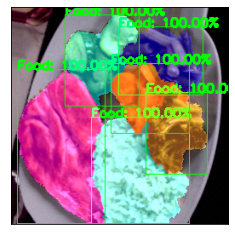

In [121]:
# show dataset examples with data augmentation

startIdx = 0

for idx in range(startIdx,startIdx + 1):
  img, label = dataset2visualize[idx]
  img = img.permute(1,2,0).numpy() # tensor image has different dimensions. Permute when converting to numpy
  img *= 255 # tensors are between 0 and 1. Rescale between 0 and 255
  img = img.astype(np.uint8) # convert tensor type to uint8


  masks = [mask.numpy() for mask in label["masks"]]
  boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(label['boxes'].detach().numpy())]
  labels = [codes[id] for id in (label["labels"])]
  scores = [1]*len(labels)

  drawPrediction(img, masks, boxes, labels,scores)

## Model

In [122]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [123]:
#### freeze only backbone

def freezeBackboneLayer(model):
  for param in model.backbone.parameters():
    param.requires_grad=False

  for param in model.rpn.parameters():
    param.requires_grad=True
  for param in model.roi_heads.parameters():
    param.requires_grad=True

def unfreezeBackboneLayer(model):
  for param in model.backbone.parameters():
    param.requires_grad=True

  for param in model.rpn.parameters():
    param.requires_grad=True
  for param in model.roi_heads.parameters():
    param.requires_grad=True

In [98]:
# test model inputs and outputs

# images,targets = next(iter(trainDataloader))
# # images = list(image for image in images)
# # targets = [{k: v for k, v in t.items()} for t in targets]

# model = get_model_instance_segmentation(len(codes))
# output = model(images,targets)   # Returns losses and detections
# print(output)

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions
# print(predictions[0])

## Use Pytorch Lightning to train

In [125]:
sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/torchvisionReferences/detection') #make src files importable
from torchvisionReferences.detection.engine import train_one_epoch, evaluate
import torch
from typing import List, Tuple
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import torchmetrics
import wandb
wandb.login()

class MaskRCNN(LightningModule):

    def __init__(self, lr=None, weight_decay=None, epochs=None, freezeBackbone=True):
        super().__init__()

        self.modelMaskrcnn = get_model_instance_segmentation(num_classes=len(codes))
        self.modelMaskrcnn.transform.min_size = (imageSize,)
        self.modelMaskrcnn.transform.max_size = imageSize
        if freezeBackbone:
          self.freeze()

        # hparams
        self.max_epochs = epochs
        self.lr = lr if lr is not None else 0.01
        self.weight_decay = weight_decay if weight_decay is not None else 0.1

        # metrics
        self.predsThreshold = 0.8
        self.val_mAP = torchmetrics.MAP(class_metrics=False)
        self.test_mAP = torchmetrics.MAP(class_metrics=True)
        self.acc = torchmetrics.Accuracy(ignore_index=0)
        self.miou = torchmetrics.IoU(num_classes=len(codes), ignore_index=0, absent_score=1.0, reduction="elementwise_mean") # reduction = "none" or "elementwise_mean"
    
    def freeze(self):
      freezeBackboneLayer(self.modelMaskrcnn)
    
    def unfreeze(self):
      unfreezeBackboneLayer(self.modelMaskrcnn)

    def forward(self, input, target=None):
        if target is not None:
          return self.modelMaskrcnn(input, target) #train mode
        else: 
          return self.modelMaskrcnn(input) #eval mode
    
    def configure_optimizers(self):
        print("Configuring optimizer and setting sanity check to TRUE")
        self.validationSanityCheck = True
        params = [p for p in self.parameters() if p.requires_grad]
        optim = torch.optim.AdamW(params, lr=self.lr, weight_decay=self.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=self.lr,
                                                 steps_per_epoch=len(trainDataloader), epochs=self.max_epochs,
                                                 cycle_momentum=True)   

        return {
            "optimizer": optim,
            "lr_scheduler": lr_scheduler
        }

    
    def training_step(self, batch, batch_idx):
        x, y = batch
        loss_dict = self(x, y)
        loss = sum(loss for loss in loss_dict.values())
        
        metrics = {}
        metrics["loss"] = loss
        self.log_dict(metrics, on_step=True, on_epoch=True)

        return metrics

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        
        flat_pred, flat_target = concatenateAndFlattenMasks(preds, y, threshold=self.predsThreshold, pytorchDevice=self.device)
        self.acc.update(flat_pred, flat_target)
        self.miou.update(flat_pred, flat_target)         
        self.val_mAP.update(preds,y)


    def validation_epoch_end(self, outputs):
        # COCO evaluation
        # if self.validationSanityCheck is False:
        #   results = evaluate(self.modelMaskrcnn, testDataloader, device=self.device)
        # else:
        #   self.validationSanityCheck = False

        metricsAvg = {}

        metricsAvg = self.val_mAP.compute()
        self.val_mAP.reset()

        accuracy = self.acc.compute()
        metricsAvg["acc_segmentation"] = accuracy
        self.acc.reset()

        miouScore = self.miou.compute()
        metricsAvg["miou"] = miouScore
        self.miou.reset()

        print("Validation metrics")
        print("-----------------------------\n")
        [print(f"{metric}: {value}") for metric, value in metricsAvg.items()]
        print("\n-----------------------------")

        self.log_dict(metricsAvg, on_step=False, on_epoch=True, logger=True)
        return metricsAvg

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        
        flat_pred, flat_target = concatenateAndFlattenMasks(preds, y, threshold=self.predsThreshold, pytorchDevice=self.device)
        self.acc.update(flat_pred, flat_target)
        self.miou.update(flat_pred, flat_target)
        self.test_mAP.update(preds, y)


    def test_epoch_end(self, outputs):
        metricsAvg = {}

        metricsAvg = self.test_mAP.compute()
        self.test_mAP.reset()

        accuracy = self.acc.compute()
        metricsAvg["acc_segmentation"] = accuracy
        self.acc.reset()

        miouScore = self.miou.compute()
        metricsAvg["miou"] = miouScore
        self.miou.reset()

        print("Test metrics")
        print("-----------------------------\n")
        [print(f"{metric}: {value}") for metric, value in metricsAvg.items()]
        print("\n-----------------------------")

        self.log_dict(metricsAvg, on_step=False, on_epoch=True, logger=True)
        return metricsAvg



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [126]:
# set hyperparameters
lr = 1e-3
wd = 5e-4
epochs = 5
grad_accumulation_batches = int(32/bs) # 32 is the final "batch size"

modelMaskrcnn = MaskRCNN(lr=lr, weight_decay=wd, epochs=epochs, freezeBackbone=True)

# load pretrained model if necessary
# modelMaskrcnn.load_state_dict(torch.load(path + "models/maskrcnnTorchLightningTraining-finetunning.pt"))

In [127]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, QuantizationAwareTraining
from pytorch_lightning.loggers import WandbLogger
import wandb

wandb_logger = WandbLogger(project="diabetesLearning-instanceSegmentation", log_model=False)
wandb_logger.watch(modelMaskrcnn, log='all', log_freq=100)

checkpoint_callback = ModelCheckpoint(monitor='map', mode="max", verbose=True)
# checkpoint_callback = ModelCheckpoint(monitor='loss', mode="min", verbose=True)
# early_stop_callback = EarlyStopping(monitor='val_loss', mode="min", patience=50, verbose=True)
callbacks = [checkpoint_callback]

trainer = Trainer(gpus= 1 if torch.cuda.is_available() else 0,
            max_epochs=epochs, 
            accumulate_grad_batches=grad_accumulation_batches,
            # gradient_clip_val=1.0,
            # amp_backend='apex',
            # amp_level='02',
            precision=32,
            logger=wandb_logger,
            callbacks=callbacks
            )


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | modelMaskrcnn | MaskRCNN | 43.9 M
1 | val_mAP       | MAP      | 0     
2 | test_mAP      | MAP      | 0     
3 | acc           | Accuracy | 0     
4 | miou          | IoU      | 0     
-------------------------------------------
17.1 M    Trainable params
26.8 M    Non-trainable params
43.9 M    Total params
175.690   Total estimated model params size (MB)


Configuring optimizer and setting sanity check to TRUE


Finding best initial lr:   0%|          | 0/50 [00:00<?, ?it/s]

LR finder stopped early after 43 steps due to diverging loss.
Restoring states from the checkpoint file at /content/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /content/lr_find_temp_model.ckpt


Suggested lr: 0.05248074602497723


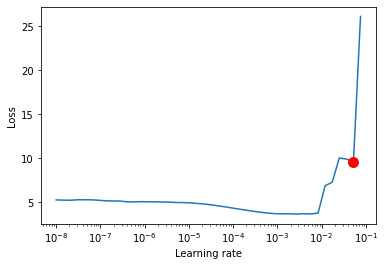

In [128]:
# lr finder

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(modelMaskrcnn, train_dataloaders=trainDataloader, num_training=50)
lr = lr_finder.suggestion()
print("Suggested lr:",lr)

fig = lr_finder.plot(suggest=True)
fig.show()


In [129]:
modelMaskrcnn.lr = 1e-3
wandb_logger.log_hyperparams({"lr": lr, "wd": wd, "epochs": epochs, "bs": bs})

### Training with frozen backbone

In [130]:
# train last layers
modelMaskrcnn.freeze()
print("START TRAINING WITH FROZEN LAYERS")
trainer.fit(modelMaskrcnn, trainDataloader, testDataloader)

modelMaskrcnn = MaskRCNN.load_from_checkpoint(checkpoint_path=checkpoint_callback.best_model_path)
torch.save(modelMaskrcnn.state_dict(), path + "models/temp-maskrcnn-FoodDetection-Unimib.pt")
print(checkpoint_callback.best_model_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | modelMaskrcnn | MaskRCNN | 43.9 M
1 | val_mAP       | MAP      | 0     
2 | test_mAP      | MAP      | 0     
3 | acc           | Accuracy | 0     
4 | miou          | IoU      | 0     
-------------------------------------------
17.1 M    Trainable params
26.8 M    Non-trainable params
43.9 M    Total params
175.690   Total estimated model params size (MB)


START TRAINING WITH FROZEN LAYERS
Configuring optimizer and setting sanity check to TRUE


Validation sanity check: 0it [00:00, ?it/s]

Validation metrics
-----------------------------

map: 0.015386932529509068
map_50: 0.09384997189044952
map_75: 0.0003563096688594669
map_small: 0.0
map_medium: 0.015997450798749924
map_large: 0.0474163293838501
mar_1: 0.007317072711884975
mar_10: 0.06097560375928879
mar_100: 0.2341463267803192
mar_small: 0.0
mar_medium: 0.21052631735801697
mar_large: 0.2666667103767395
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.0
miou: 0.0

-----------------------------


Training: 343it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 44: map reached 0.28103 (best 0.28103), saving model to "/content/diabetesLearning-instanceSegmentation/x1c7ulii/checkpoints/epoch=0-step=44.ckpt" as top 1


Validation metrics
-----------------------------

map: 0.2810295522212982
map_50: 0.6113338470458984
map_75: 0.2309182733297348
map_small: 0.01994967833161354
map_medium: 0.28044894337654114
map_large: 0.3136852979660034
mar_1: 0.10651340335607529
mar_10: 0.4379310607910156
mar_100: 0.5222222208976746
mar_small: 0.375
mar_medium: 0.5446043014526367
mar_large: 0.5038135647773743
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.7742716670036316
miou: 0.7742716670036316

-----------------------------
Degenerated bounding box!!!!!!! Fixing error


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 88: map reached 0.33953 (best 0.33953), saving model to "/content/diabetesLearning-instanceSegmentation/x1c7ulii/checkpoints/epoch=1-step=88.ckpt" as top 1


Validation metrics
-----------------------------

map: 0.3395298421382904
map_50: 0.6945891380310059
map_75: 0.29051369428634644
map_small: 0.09943117201328278
map_medium: 0.33485645055770874
map_large: 0.35691940784454346
mar_1: 0.12490421533584595
mar_10: 0.47643670439720154
mar_100: 0.5480842590332031
mar_small: 0.3499999940395355
mar_medium: 0.5550359487533569
mar_large: 0.548305094242096
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.8372665643692017
miou: 0.8372665643692017

-----------------------------


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 132: map reached 0.38750 (best 0.38750), saving model to "/content/diabetesLearning-instanceSegmentation/x1c7ulii/checkpoints/epoch=2-step=132.ckpt" as top 1


Validation metrics
-----------------------------

map: 0.38749733567237854
map_50: 0.7328343391418457
map_75: 0.3586132228374481
map_small: 0.09805244952440262
map_medium: 0.3610348403453827
map_large: 0.4339975416660309
mar_1: 0.13409960269927979
mar_10: 0.5072796940803528
mar_100: 0.5766283273696899
mar_small: 0.2874999940395355
mar_medium: 0.5758993029594421
mar_large: 0.5881356000900269
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.8553193211555481
miou: 0.8553193211555481

-----------------------------


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 176: map reached 0.40883 (best 0.40883), saving model to "/content/diabetesLearning-instanceSegmentation/x1c7ulii/checkpoints/epoch=3-step=176.ckpt" as top 1


Validation metrics
-----------------------------

map: 0.40882620215415955
map_50: 0.7536377310752869
map_75: 0.39830365777015686
map_small: 0.1324487328529358
map_medium: 0.3859642744064331
map_large: 0.45172590017318726
mar_1: 0.13812261819839478
mar_10: 0.5201149582862854
mar_100: 0.5791187882423401
mar_small: 0.3375000059604645
mar_medium: 0.5802158117294312
mar_large: 0.5877118706703186
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.8419821858406067
miou: 0.8419821858406067

-----------------------------


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 220: map was not in top 1


Validation metrics
-----------------------------

map: 0.40770113468170166
map_50: 0.7694476842880249
map_75: 0.38086336851119995
map_small: 0.14967522025108337
map_medium: 0.3654937148094177
map_large: 0.469787061214447
mar_1: 0.13620689511299133
mar_10: 0.5214558839797974
mar_100: 0.574904203414917
mar_small: 0.2874999940395355
mar_medium: 0.5730215311050415
mar_large: 0.5872880816459656
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.8625068664550781
miou: 0.8625068664550781

-----------------------------
/content/diabetesLearning-instanceSegmentation/x1c7ulii/checkpoints/epoch=3-step=176.ckpt


### Fine tunning

In [132]:
# finetune everything

epochs = 5
modelMaskrcnn.unfreeze()
modelMaskrcnn.lr = modelMaskrcnn.lr/2
modelMaskrcnn.max_epochs = epochs

trainer = Trainer(gpus= 1 if torch.cuda.is_available() else 0,
            max_epochs=epochs, 
            accumulate_grad_batches=grad_accumulation_batches,
            # gradient_clip_val=1.0,
            # amp_backend='apex',
            # amp_level='02',
            precision=32,
            logger=wandb_logger,
            callbacks=callbacks
            )

print("START FINETUNNING")
trainer.fit(modelMaskrcnn, trainDataloader, testDataloader)

wandb.save(checkpoint_callback.best_model_path)

modelMaskrcnn = MaskRCNN.load_from_checkpoint(checkpoint_path=checkpoint_callback.best_model_path)
torch.save(modelMaskrcnn.state_dict(), path + "models/maskrcnn-FoodDetection-Unimib.pt")
print(checkpoint_callback.best_model_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


START FINETUNNING
Configuring optimizer and setting sanity check to TRUE



  | Name          | Type     | Params
-------------------------------------------
0 | modelMaskrcnn | MaskRCNN | 43.9 M
1 | val_mAP       | MAP      | 0     
2 | test_mAP      | MAP      | 0     
3 | acc           | Accuracy | 0     
4 | miou          | IoU      | 0     
-------------------------------------------
43.9 M    Trainable params
0         Non-trainable params
43.9 M    Total params
175.690   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Validation metrics
-----------------------------

map: 0.5603886842727661
map_50: 0.853861391544342
map_75: 0.5965309143066406
map_small: 0.0
map_medium: 0.4378856122493744
map_large: 0.693204939365387
mar_1: 0.1609756052494049
mar_10: 0.6219512224197388
mar_100: 0.6219512224197388
mar_small: 0.0
mar_medium: 0.5421051979064941
mar_large: 0.7333333492279053
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.9383040070533752
miou: 0.9383040070533752

-----------------------------


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 43: map was not in top 1


Validation metrics
-----------------------------

map: 0.44039198756217957
map_50: 0.7990773916244507
map_75: 0.439140647649765
map_small: 0.02995053119957447
map_medium: 0.4022364616394043
map_large: 0.5074164867401123
mar_1: 0.14099617302417755
mar_10: 0.5371648073196411
mar_100: 0.5812260508537292
mar_small: 0.30000001192092896
mar_medium: 0.5705036520957947
mar_large: 0.6033898591995239
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.8301341533660889
miou: 0.8301341533660889

-----------------------------


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 87: map was not in top 1


Validation metrics
-----------------------------

map: 0.48981648683547974
map_50: 0.826633870601654
map_75: 0.5115527510643005
map_small: 0.05196308717131615
map_medium: 0.44499051570892334
map_large: 0.5578868985176086
mar_1: 0.1429118812084198
mar_10: 0.5844827890396118
mar_100: 0.6103448271751404
mar_small: 0.30000001192092896
mar_medium: 0.5960432291030884
mar_large: 0.6411017179489136
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.8821675777435303
miou: 0.8821675777435303

-----------------------------


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 131: map was not in top 1


Validation metrics
-----------------------------

map: 0.49320876598358154
map_50: 0.8343098163604736
map_75: 0.5268747806549072
map_small: 0.003388563171029091
map_medium: 0.4434104859828949
map_large: 0.5776734352111816
mar_1: 0.14827585220336914
mar_10: 0.5969349145889282
mar_100: 0.6306513547897339
mar_small: 0.08749999850988388
mar_medium: 0.6291366815567017
mar_large: 0.6542372107505798
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.9216643571853638
miou: 0.9216643571853638

-----------------------------


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 175: map was not in top 1


Validation metrics
-----------------------------

map: 0.5238816142082214
map_50: 0.8460032343864441
map_75: 0.5743930339813232
map_small: 0.047591812908649445
map_medium: 0.4824313223361969
map_large: 0.5908934473991394
mar_1: 0.15153256058692932
mar_10: 0.6080459356307983
mar_100: 0.6381226181983948
mar_small: 0.36250001192092896
mar_medium: 0.6237410306930542
mar_large: 0.6682203412055969
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.9342414140701294
miou: 0.9342414140701294

-----------------------------


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 219: map was not in top 1


Validation metrics
-----------------------------

map: 0.5394517183303833
map_50: 0.8639594316482544
map_75: 0.5988304018974304
map_small: 0.020644450560212135
map_medium: 0.4891243278980255
map_large: 0.6151583790779114
mar_1: 0.14846745133399963
mar_10: 0.6281608939170837
mar_100: 0.6524904370307922
mar_small: 0.22499999403953552
mar_medium: 0.6410071849822998
mar_large: 0.681355893611908
map_per_class: tensor([-1.])
mar_100_per_class: tensor([-1.])
acc_segmentation: 0.9216963648796082
miou: 0.9216963648796082

-----------------------------


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


/content/diabetesLearning-instanceSegmentation/x1c7ulii/checkpoints/epoch=4-step=219.ckpt


In [ ]:
while True: pass

## Error Analysis

In [134]:
# evaluate using torchmetrics

testTrainer = Trainer(gpus=1)
testTrainer.test(model=modelMaskrcnn, dataloaders=testDataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Test metrics
-----------------------------

map: 0.5399236083030701
map_50: 0.8659668564796448
map_75: 0.5986156463623047
map_small: 0.0317859873175621
map_medium: 0.4873526990413666
map_large: 0.6162019968032837
mar_1: 0.15766283869743347
mar_10: 0.6128352284431458
mar_100: 0.6310344934463501
mar_small: 0.1875
mar_medium: 0.6053956747055054
mar_large: 0.6783897876739502
map_per_class: tensor([0.5399])
mar_100_per_class: tensor([0.6310])
acc_segmentation: 0.9286090731620789
miou: 0.9286090731620789

-----------------------------
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc_segmentation': 0.9286090731620789,
 'map': 0.5399236083030701,
 'map_50': 0.8659668564796448,
 'map_75': 0.5986156463623047,
 'map_large': 0.6162019968032837,
 'map_medium': 0.4873526990413666,
 'map_per_class': 0.5399236083030701,
 'map_small': 0.0317859873175621,
 'mar_1': 0.15766283869743347,
 'mar_10': 0.6128352284431458,
 'mar_100': 0.6310344934

[{'acc_segmentation': 0.9286090731620789,
  'map': 0.5399236083030701,
  'map_50': 0.8659668564796448,
  'map_75': 0.5986156463623047,
  'map_large': 0.6162019968032837,
  'map_medium': 0.4873526990413666,
  'map_per_class': 0.5399236083030701,
  'map_small': 0.0317859873175621,
  'mar_1': 0.15766283869743347,
  'mar_10': 0.6128352284431458,
  'mar_100': 0.6310344934463501,
  'mar_100_per_class': 0.6310344934463501,
  'mar_large': 0.6783897876739502,
  'mar_medium': 0.6053956747055054,
  'mar_small': 0.1875,
  'miou': 0.9286090731620789}]

Food: 99.25%
Food: 98.85%
Food: 98.38%
Food: 90.08%
Food: 89.93%
Food: 89.63%


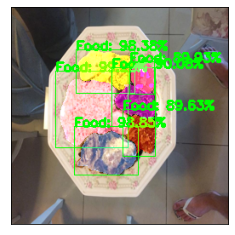

Food: 99.58%
Food: 99.37%
Food: 99.18%


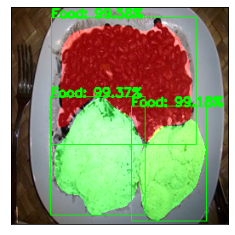

Food: 98.95%
Food: 96.85%
Food: 94.87%
Food: 93.09%
Food: 88.11%
Food: 86.61%


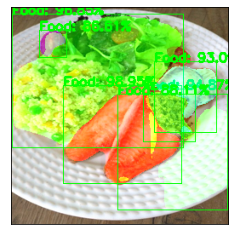

Food: 99.59%
Food: 99.47%
Food: 99.47%
Food: 99.08%
Food: 94.99%


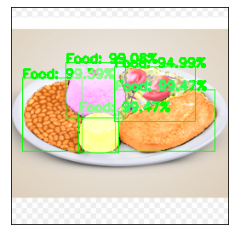

Food: 99.16%
Food: 98.96%
Food: 98.69%
Food: 97.23%
Food: 89.85%


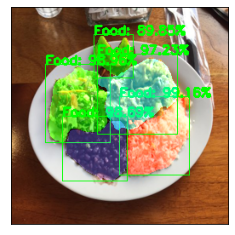

Food: 99.49%
Food: 99.47%
Food: 99.09%
Food: 98.58%
Food: 98.33%
Food: 98.24%
Food: 89.87%


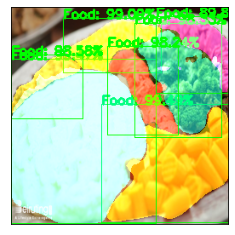

Food: 99.02%
Food: 98.96%
Food: 95.77%


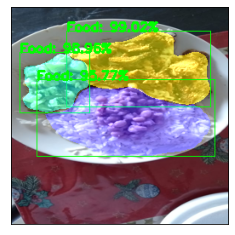

Food: 99.57%
Food: 99.21%
Food: 97.48%
Food: 96.32%
Food: 92.94%


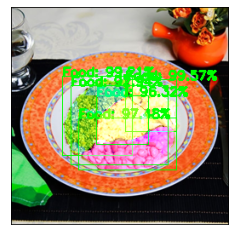

Food: 99.64%
Food: 98.70%
Food: 98.68%
Food: 98.66%
Food: 98.41%
Food: 98.06%
Food: 97.55%
Food: 91.40%
Food: 88.40%


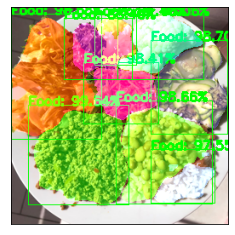

Food: 99.63%
Food: 99.08%
Food: 98.89%
Food: 98.79%
Food: 98.17%
Food: 90.11%
Food: 81.05%


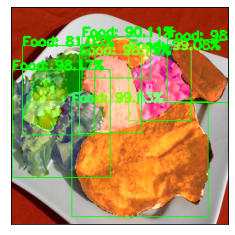

Food: 99.24%
Food: 98.28%
Food: 97.96%
Food: 97.31%
Food: 97.13%


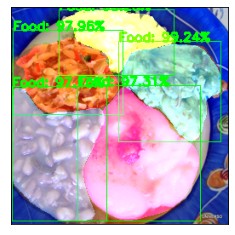

Food: 99.57%


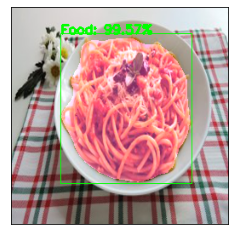

Food: 99.38%
Food: 99.00%
Food: 98.99%
Food: 98.15%
Food: 97.03%


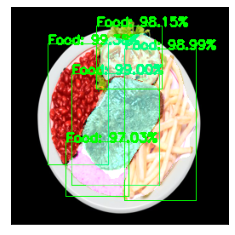

Food: 99.36%
Food: 99.32%
Food: 99.15%
Food: 99.13%
Food: 98.90%
Food: 97.73%
Food: 85.96%


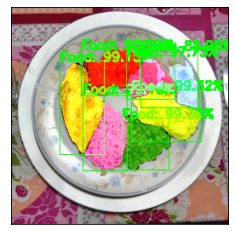

Food: 99.09%
Food: 98.98%
Food: 98.25%
Food: 84.15%


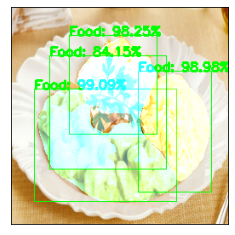

Food: 99.63%


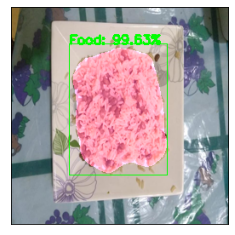

Food: 99.06%
Food: 98.75%
Food: 98.11%
Food: 95.81%


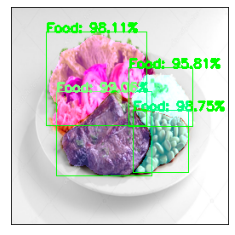

Food: 99.29%
Food: 95.50%
Food: 94.84%
Food: 88.48%


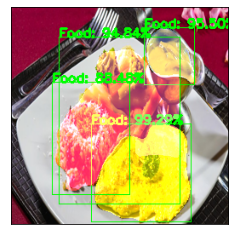

Food: 99.25%
Food: 98.93%
Food: 98.28%
Food: 94.81%


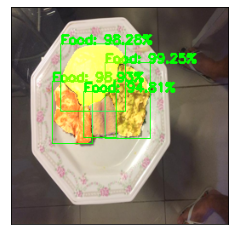

Food: 99.45%
Food: 99.24%
Food: 98.59%
Food: 98.16%
Food: 97.77%
Food: 97.15%
Food: 95.09%


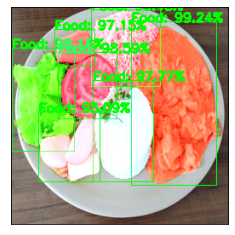

In [133]:
# validate

start = 10
modelMaskrcnn.to(device)
modelMaskrcnn.eval()

for idx in range(start,start+20):
  instance_segmentation_api(str(X_test[idx]), codes, modelMaskrcnn, threshold=0.8)

In [ ]:
# evaluate using torchvision engine

# evaluate(modelMaskrcnn, testDataloader, device=device)

In [ ]:
# # evaluate with acc_segmentation

# def acc_segmentationMaskRCNN(y_pred, y_target, threshold=0.8): # y_pred and y_target are lists of dicts (batches)
#   flat_pred, flat_target = concatenateAndFlattenMasks(y_pred, y_target,threshold=threshold)
#   void_code = 0
#   mask = flat_target != void_code
#   return (flat_pred[mask]==flat_target[mask]).float().mean()

# from statistics import mean

# acc_total = []
# modelMaskrcnn.to(torch.device("cpu"))
# modelMaskrcnn.eval()
# for batch in testDataloader:
#   x, y = batch
#   preds = modelMaskrcnn(x)
#   acc_batch = acc_segmentationMaskRCNN(preds, y)
#   acc_total.append(acc_batch.item())

# print("Final acc_segmentation:", mean(acc_total))

## Predictions

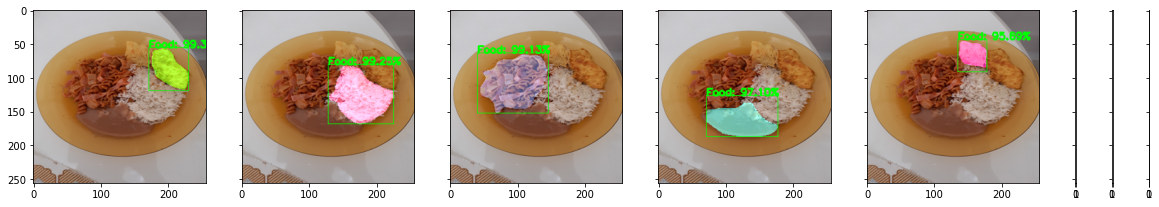

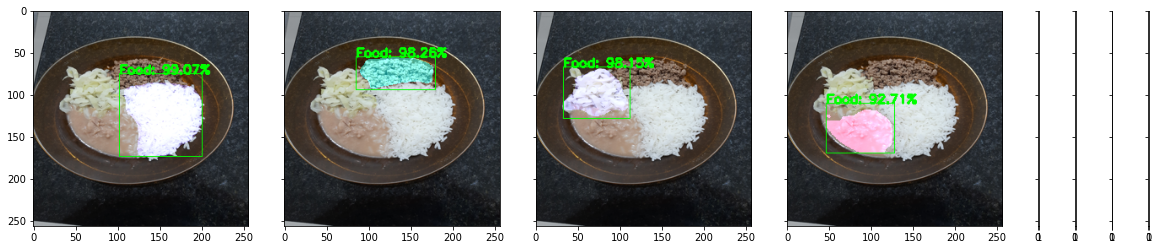

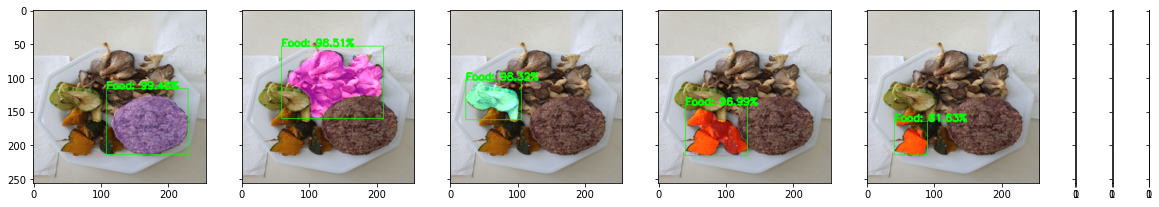

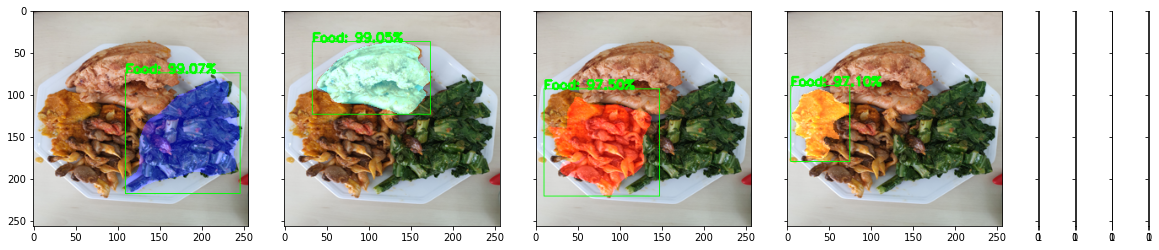

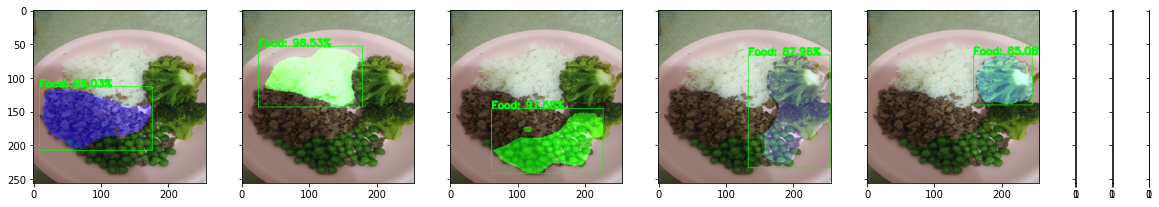

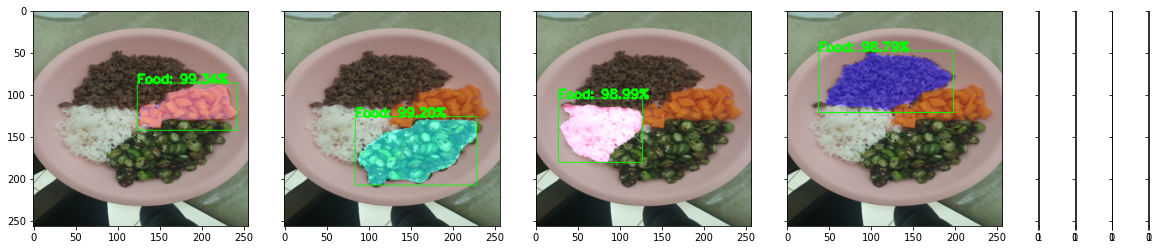

In [157]:
filepaths = ["./mara1.png","./mara2.png", "joseila1.png","joseila2.png","joseila3.png", "joseila4.png"]

modelMaskrcnn.to(device)
modelMaskrcnn.eval()

for file in filepaths:
  instance_segmentation_api(file, codes, modelMaskrcnn, threshold=0.8)
  print("\n\n")

## Use torchvision engine to train

In [ ]:
sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/torchvisionReferences/detection') #make src files importable
from torchvisionReferences.detection.engine import train_one_epoch, evaluate

In [ ]:
modelMaskrcnn = get_model_instance_segmentation(num_classes=len(codes))
modelMaskrcnn.transform.min_size = (imageSize,)
modelMaskrcnn.transform.max_size = imageSize

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
modelMaskrcnn.to(device)

# load trained model
# modelMaskrcnn.load_state_dict(torch.load(path + "maskrcnnTorchvisionTraining-77Classes.pt"))

### Training with frozen backbone

In [ ]:
# construct an optimizer

freezeBackboneLayer(modelMaskrcnn)
params = [p for p in modelMaskrcnn.parameters() if p.requires_grad]

lr = 0.001
wd = 0.0005
num_epochs = 20

optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=wd)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                 step_size=3,
#                                                 gamma=0.1)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                 steps_per_epoch=len(trainDataloader), epochs=num_epochs,
                                                 cycle_momentum=True)


In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(modelMaskrcnn, optimizer, trainDataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    results = evaluate(modelMaskrcnn, testDataloader, device=device)

torch.save(modelMaskrcnn.state_dict(), path + "models/maskrcnnTorchvisionTraining-foodDetection.pt")

### Fine tunning

In [ ]:
# construct an optimizer

unfreezeBackboneLayer(modelMaskrcnn)
params = [p for p in modelMaskrcnn.parameters() if p.requires_grad]

lr = lr/2
wd = 0.0005
num_epochs = 20

optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=wd)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                 step_size=3,
#                                                 gamma=0.1)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                 steps_per_epoch=len(trainDataloader), epochs=num_epochs,
                                                 cycle_momentum=True)


In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(modelMaskrcnn, optimizer, trainDataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    results = evaluate(modelMaskrcnn, testDataloader, device=device)

torch.save(modelMaskrcnn.state_dict(), path + "models/maskrcnnTorchvisionTraining-foodDetection-finetunning.pt")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [0/1]  eta: 0:00:01  lr: 0.000020  loss: 0.4243 (0.4243)  loss_classifier: 0.0481 (0.0481)  loss_box_reg: 0.1257 (0.1257)  loss_mask: 0.2487 (0.2487)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 1.1273  data: 0.8101  max mem: 8670
Epoch: [0] Total time: 0:00:01 (1.4066 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:00  model_time: 0.1014 (0.1014)  evaluator_time: 0.0085 (0.0085)  time: 0.8021  data: 0.6913  max mem: 8670
Test: Total time: 0:00:01 (1.0464 s / it)
Averaged stats: model_time: 0.1014 (0.1014)  evaluator_time: 0.0085 (0.0085)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.651
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50